### Power and coherence are dynamic

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from frites.stats import confidence_interval
from frites.utils import parallel_func
from tqdm import tqdm
from utils import *

from config import get_dates, return_delay_split
from GDa.flatmap.flatmap import flatmap
from GDa.loader import loader

##### Setting configurations

In [5]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [6]:
metric = "coh"
monkey = "lucy"
ds = 1

In [7]:
early_cue, early_delay = return_delay_split(monkey, delay_type=ds)

In [8]:
sessions = get_dates(monkey)

In [10]:
stages = [[-0.5, 0], [0, 0.5], [0.5, 1.5], [1.5, 2.0]]

##### Auxiliar functions

In [11]:
def compute_time_series_cv(data):
    """
    Compute the coefficient of variation (CV) of a time series.

    The CV is defined as the standard deviation divided by the mean of the time series. This function also computes a confidence interval for the CV at a specified level.

    Parameters
    ----------
    data : xarray.DataArray
        The time series data. It should have dimensions 'roi', 'trials', and 'times'.

    Returns
    -------
    cv : xarray.DataArray
        The coefficient of variation of the time series data. It has dimensions 'roi', 'trials', and 'times'.
    """
    cv = data.std("times") / data.mean("times")
    return confidence_interval(cv, cis=95, axis=2, n_boots=1000, verbose=False)

In [12]:
data_loader = loader(_ROOT=_ROOT)

In [13]:
colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

#### Single sessions

In [13]:
kw_loader = dict(
    session="141024", aligned_at="cue", channel_numbers=False, monkey=monkey
)

In [14]:
power_task = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)
power_fix = data_loader.load_power(**kw_loader, trial_type=2, behavioral_response=0)

In [15]:
_, rois, freqs, times = power_task.coords.values()

In [16]:
# Get the region name for each roi
areas_dict = get_areas()
regions = np.asarray([areas_dict[roi.lower()] for roi in rois.data])

In [17]:
cv_task = compute_time_series_cv(power_task)
cv_fix = compute_time_series_cv(power_fix)

In [18]:
x = cv_task.assign_coords({"roi": regions}).groupby("roi").median("roi").squeeze()
y = cv_fix.assign_coords({"roi": regions}).groupby("roi").median("roi").squeeze()

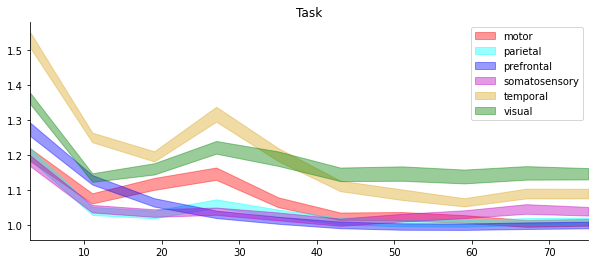

In [19]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for r in np.unique(regions):

    plt.fill_between(
        freqs,
        x.sel(bound="low", roi=r),
        x.sel(bound="high", roi=r),
        alpha=0.4,
        color=colors[r],
        label=r,
    )
plt.xlim(3, 75)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.title("Task")
plt.legend()

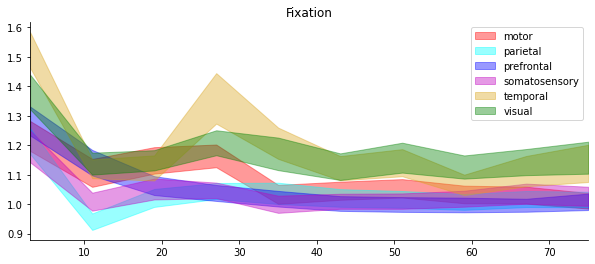

In [20]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for r in np.unique(regions):

    plt.fill_between(
        freqs,
        y.sel(bound="low", roi=r),
        y.sel(bound="high", roi=r),
        alpha=0.4,
        color=colors[r],
        label=r,
    )
plt.xlim(3, 75)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.title("Fixation")
plt.legend()

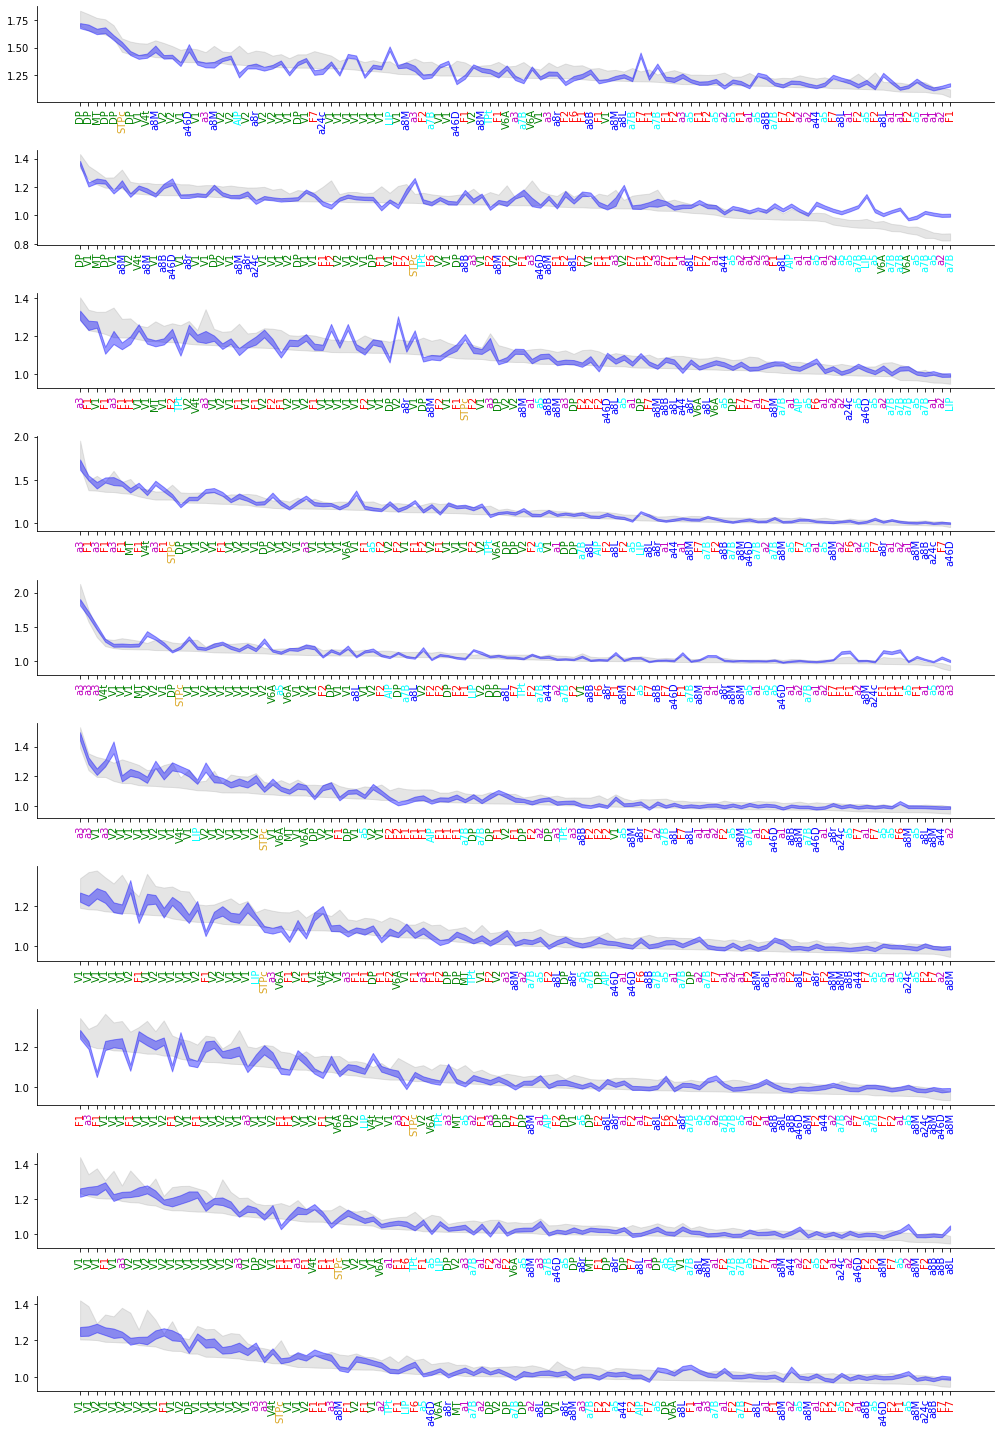

In [21]:
plt.figure(figsize=(14, 20))
for i in range(10):
    ax = plt.subplot(10, 1, i + 1)
    # Fixation
    lower = cv_fix.squeeze().sel(bound="low").isel(freqs=i)
    higher = cv_fix.squeeze().sel(bound="high").isel(freqs=i)
    idx = np.argsort(lower)[::-1].data
    plt.fill_between(range(105), lower[idx], higher[idx], color="grey", alpha=0.2)

    # Task
    lower = cv_task.squeeze().sel(bound="low").isel(freqs=i)
    higher = cv_task.squeeze().sel(bound="high").isel(freqs=i)
    plt.fill_between(range(105), lower[idx], higher[idx], color="b", alpha=0.4)
    tks = plt.xticks(range(105), rois.data[idx], rotation=90)
    [tks[1][i].set_color(colors[r]) for i, r in enumerate(regions[idx])]
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.tight_layout()

In [30]:
def compute_power_pval(power_task, power_fix, stages):
    pvals = []
    for t0, t1 in stages:
        _, temp = stats.kruskal(
            power_fix.sel(times=slice(t0, t1)),
            power_task.sel(times=slice(t0, t1)),
            axis=(2, 3),
        )
        pvals += [temp]

    pvals = np.stack(pvals, -1)
    pvals = xr.DataArray(
        pvals,
        dims=("roi", "freqs", "times"),
        coords=(power_fix.roi, freqs, ["P", "S", "D", "Dm"]),
    )

    return pvals


def compute_crackle_pval(raster_task, raster_fix, stages):
    pvals = []
    for i in range(raster_task.sizes["times"]):
        _, temp = stats.kruskal(
            raster_fix.isel(times=i),
            raster_task.isel(times=i),
            axis=2,
        )
        pvals += [temp]

    pvals = np.stack(pvals, -1)
    pvals = xr.DataArray(
        pvals,
        dims=("roi", "freqs", "times"),
        coords=(raster_task.roi, freqs, ["P", "S", "D", "Dm"]),
    )

    return pvals


def plot_tile_maps(values, regions, vmin=0, vmax=0.8):
    idx = np.argsort(regions)

    for i in range(values.sizes["times"]):

        plt.subplot(1, 4, i + 1)

        plt.imshow(
            values.isel(times=i)[idx],
            aspect="auto",
            origin="lower",
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
        )

        if i == 0:
            tks = plt.yticks(range(len(values.roi)), values.roi.data[idx])
            [tks[1][j].set_color(colors[r]) for j, r in enumerate(regions[idx])]
        else:
            plt.yticks([])

        plt.xticks(range(len(freqs)), values.freqs.data.astype(int), rotation=90)
        plt.xlabel("Hz")
        plt.title(f"{values.times[i].data}")

In [23]:
power_pvals = compute_power_pval(power_task, power_fix, stages)

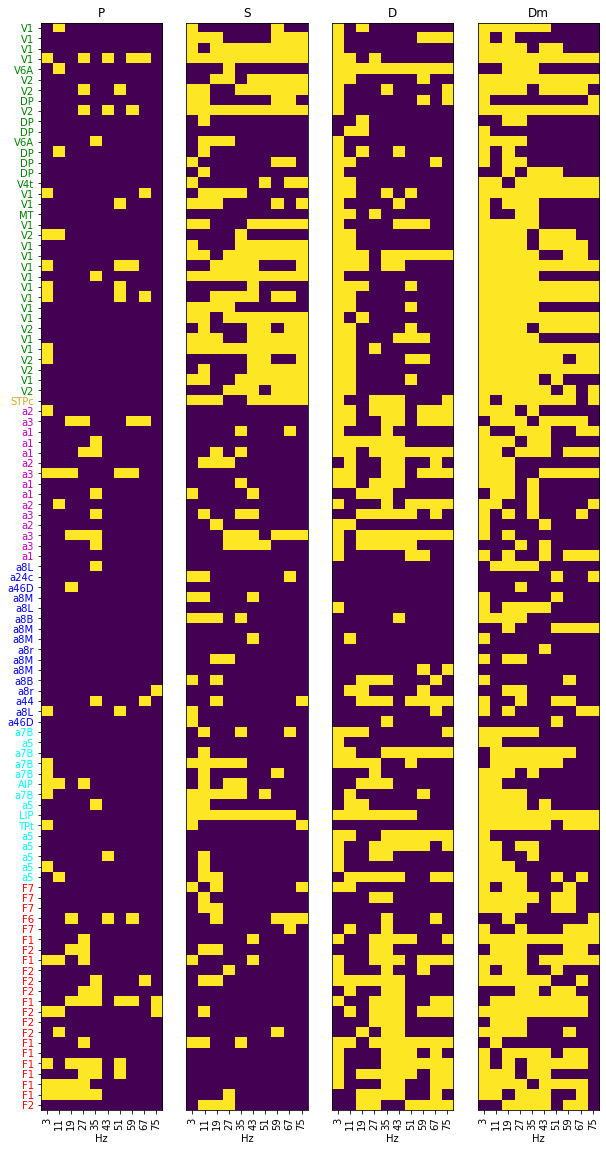

In [24]:
plt.figure(figsize=(10, 20))
plot_tile_maps(power_pvals <= 0.0001, regions)

In [25]:
thr_fix = power_fix.quantile(0.9, ("trials", "times"))
thr_task = power_task.quantile(0.9, ("trials", "times"))

raster_fix = []
raster_task = []

for t0, t1 in tqdm(stages):
    raster_fix += [(power_fix >= thr_fix).sel(times=slice(t0, t1)).mean("times")]
    raster_task += [(power_task >= thr_task).sel(times=slice(t0, t1)).mean("times")]

100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


In [26]:
raster_task = xr.concat(raster_task, "times").transpose(*power_task.dims)
raster_fix = xr.concat(raster_fix, "times").transpose(*power_task.dims)

In [31]:
crk_pvals = compute_crackle_pval(raster_task, raster_fix, stages)

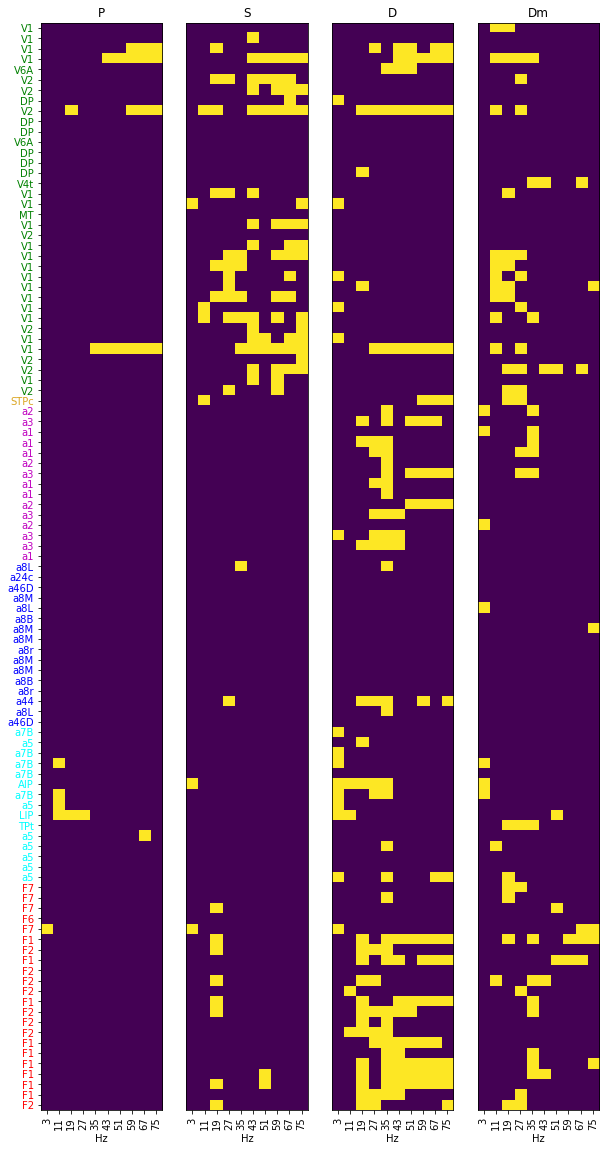

In [32]:
plt.figure(figsize=(10, 20))
plot_tile_maps(crk_pvals <= 0.0001, regions)

In [35]:
power_pvals = power_pvals <= 0.0001

In [38]:
f_i, f_j = np.triu_indices(10, k=1)

In [55]:
out = np.corrcoef(
    power_task.isel(freqs=4).stack(obs=("trials", "times")),
    power_task.isel(freqs=9).stack(obs=("trials", "times")),
)

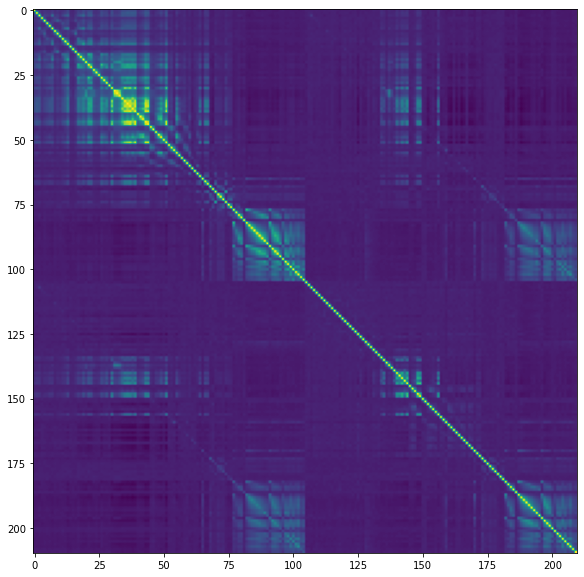

In [56]:
plt.figure(figsize=(10, 10))
plt.imshow(out)

In [164]:
from frites.utils import parallel_func


def compute_crossf_coupling(power, twin, n_jobs=1, verbose=False):
    # Number of frequency centers
    nroi, nfreqs, ntrials, ntimes = (
        power.sizes["roi"],
        power.sizes["freqs"],
        power.sizes["trials"],
        power.sizes["times"],
    )
    roi, freqs = power.roi.data, power.freqs.data.astype(int)
    # Pairs of channels
    pairs = np.stack(np.triu_indices(nroi, k=1), axis=1)
    print(pairs)
    # Pairs of frequencies
    f_s, f_t = np.triu_indices(nfreqs, k=1)

    power = (power - power.mean("times")) / power.std("times")

    def _pairwise_prod(x, pairs):
        out = []
        for s, r in pairs:
            out += [x[s] * y[r]]
        return out

    def _for_pair(i, j):

        cc = np.zeros((len(f_s), len(twin)))

        temp_power_s, temp_power_t = (
            power.isel(roi=i, freqs=f_s).data,
            power.isel(roi=j, freqs=f_t).data,
        )

        for ti, (t0, t1) in enumerate(twin):
            cc[:, ti] = (temp_power_s[:, t0:t1] * temp_power_t[:, t0:t1]).mean()

        return cc

    npairs = len(pairs)

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_pair, n_jobs=n_jobs, verbose=verbose, total=npairs
    )
    # Compute the single trial coherence
    cf = parallel(p_fun(i, j) for i, j in pairs)
    # Convert to numpy array
    cf = np.asarray(cf)

    new_freqs = [f"{f_i}-{f_j}" for f_i, f_j in zip(freqs[f_s], freqs[f_t])]
    rois = [f"{s}-{t}" for s, t in zip(roi[pairs[:, 0]], roi[pairs[:, 1]])]

    cf = xr.DataArray(
        cf, dims=("roi", "freqs", "times"), coords=dict(roi=rois, freqs=new_freqs)
    )

    return cf

In [165]:
twin = []
for t0, t1 in stages:
    t0_, t1_ = np.abs(times - t0).argmin().data, np.abs(times - t1).argmin().data
    twin += [[t0_, t1_]]

In [166]:
twin = np.vstack(twin)

In [ ]:
cf = compute_crossf_coupling(power_task, twin, n_jobs=20, verbose=True)

In [178]:
cf.roi.data[cf.sel(freqs="35.0-67.0", times=2) > 0.15]

array(['V2-V1', 'V2-V1', 'V1-V1', 'V1-V1', 'V1-V1', 'V1-V1', 'V1-V1',
       'V1-V1', 'V1-V1', 'V1-V1', 'V1-V1', 'V1-V1', 'V2-V2', 'V2-V1',
       'V1-V1', 'V1-V1', 'V1-V1', 'V1-V2', 'V1-V1', 'V1-V1', 'V1-V1',
       'V1-V1', 'V1-V1'], dtype='<U9')

#### All sessions

In [179]:
cv_fix = []
cv_task = []
for session in tqdm(sessions):

    kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

    power_task = data_loader.load_power(
        **kw_loader, trial_type=1, behavioral_response=1, session=session
    )

    power_fix = data_loader.load_power(
        **kw_loader, trial_type=2, behavioral_response=0, session=session
    )

    cv_fix += [compute_time_series_cv(power_fix)]
    cv_task += [compute_time_series_cv(power_task)]

100%|██████████| 62/62 [03:19<00:00,  3.22s/it]


In [180]:
cv_fix = node_xr_remove_sca(data_loader.apply_min_rois(cv_fix, 10))
cv_task = node_xr_remove_sca(data_loader.apply_min_rois(cv_task, 10))

In [181]:
rois = cv_task.roi.data

In [182]:
n = np.asarray([areas_dict[roi.lower()] for roi in rois])

In [183]:
cv_task = cv_task.assign_coords(dict(roi=n))
cv_fix = cv_fix.assign_coords(dict(roi=n))

In [184]:
x = cv_task.groupby("roi").median("roi").squeeze()
y = cv_fix.groupby("roi").median("roi").squeeze()

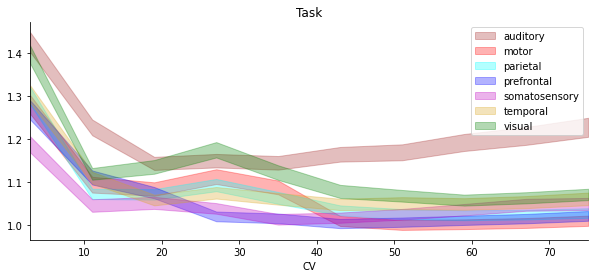

In [185]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for r in np.unique(x.roi.data):

    plt.fill_between(
        freqs,
        x.sel(bound="low", roi=r),
        x.sel(bound="high", roi=r),
        alpha=0.3,
        color=colors[r],
        label=r,
    )
plt.xlim(3, 75)
plt.xlabel("Frequency [Hz]")
plt.xlabel("CV")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.title("Task")
plt.legend()
plt.savefig("cv_all_sessions_task.png")

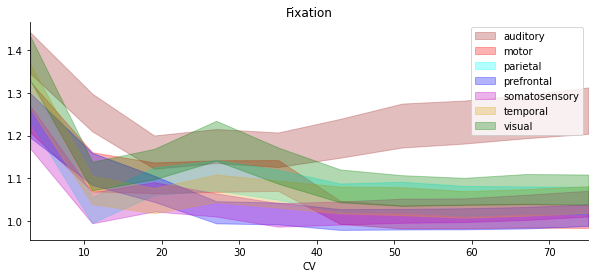

In [186]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for r in np.unique(x.roi.data):

    plt.fill_between(
        freqs,
        y.sel(bound="low", roi=r),
        y.sel(bound="high", roi=r),
        alpha=0.3,
        color=colors[r],
        label=r,
    )
plt.xlim(3, 75)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlabel("Frequency [Hz]")
plt.xlabel("CV")
plt.title("Fixation")
plt.legend()
plt.savefig("cv_all_sessions_fixation.png")

In [187]:
areas = [a.lower() for a in rois]
values = cv_task.sel(freqs=27).mean("bound").squeeze()

fmap = flatmap(values.data, areas)

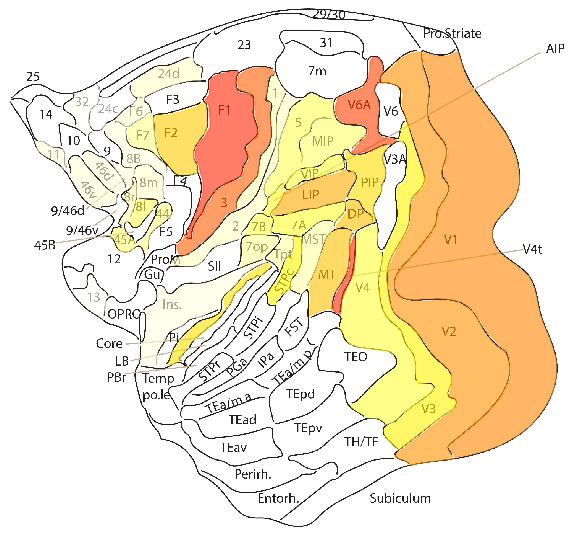

In [225]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
# Only plot colorbar for last column
fmap.plot(
    ax,
    ax_colorbar=None,
    cbar_title=None,
    vmin=1,
    vmax=1.5,
    alpha=0.6,
    colormap="hot_r",
)

In [188]:
power_pval = []
crk_pval = []
for session in tqdm(sessions):

    kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

    power_task = data_loader.load_power(
        **kw_loader, trial_type=1, behavioral_response=1, session=session
    )

    power_fix = data_loader.load_power(
        **kw_loader, trial_type=2, behavioral_response=0, session=session
    )

    thr_fix = power_fix.quantile(0.9, ("trials", "times"))
    thr_task = power_task.quantile(0.9, ("trials", "times"))

    raster_fix = []
    raster_task = []

    for t0, t1 in tqdm(stages):
        raster_fix += [(power_fix >= thr_fix).sel(times=slice(t0, t1)).mean("times")]
        raster_task += [(power_task >= thr_task).sel(times=slice(t0, t1)).mean("times")]

    raster_task = xr.concat(raster_task, "times").transpose(*power_task.dims)
    raster_fix = xr.concat(raster_fix, "times").transpose(*power_task.dims)

    power_pval += [compute_power_pval(power_task, power_fix, stages) <= 0.0001]
    crk_pval += [compute_crackle_pval(raster_task, raster_fix, stages) <= 0.0001]

100%|██████████| 62/62 [11:46<00:00, 11.39s/it]


In [189]:
power_pval = data_loader.apply_min_rois(power_pval, 10)
crk_pval = data_loader.apply_min_rois(crk_pval, 10)

In [190]:
power_pval = node_xr_remove_sca(power_pval)
crk_pval = node_xr_remove_sca(crk_pval)

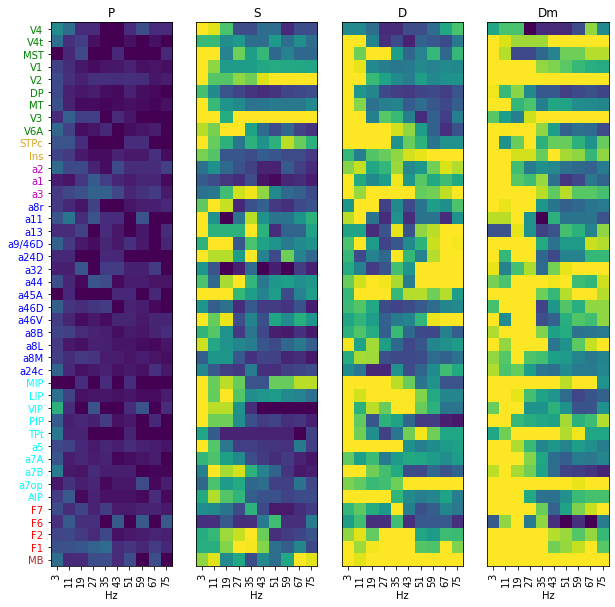

In [191]:
plt.figure(figsize=(10, 10))
plot_tile_maps(
    power_pval,
    np.asarray([areas_dict[roi.lower()] for roi in power_pval.roi.data]),
    vmin=0,
    vmax=0.6,
)
plt.savefig("sig_power.png")

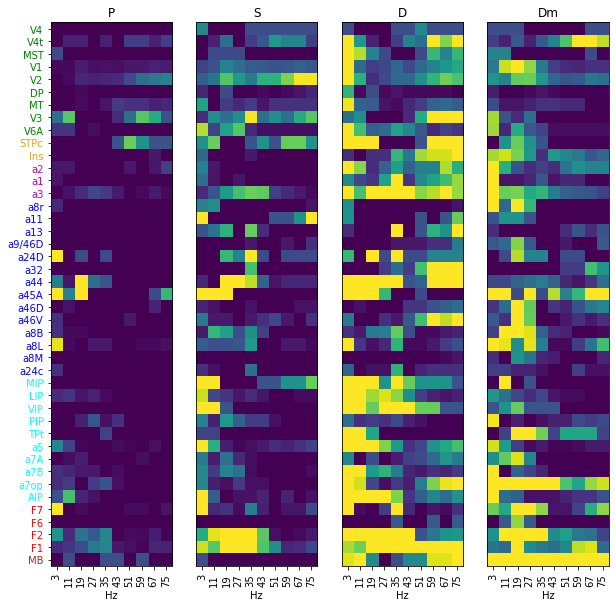

In [192]:
plt.figure(figsize=(10, 10))
plot_tile_maps(
    crk_pval,
    np.asarray([areas_dict[roi.lower()] for roi in power_pval.roi.data]),
    vmin=0,
    vmax=0.3,
)
plt.savefig("sig_crackle.png")

In [211]:
data = (crk_pval > 0.3).astype(int) * 2 + (power_pval > 0.3).astype(int)

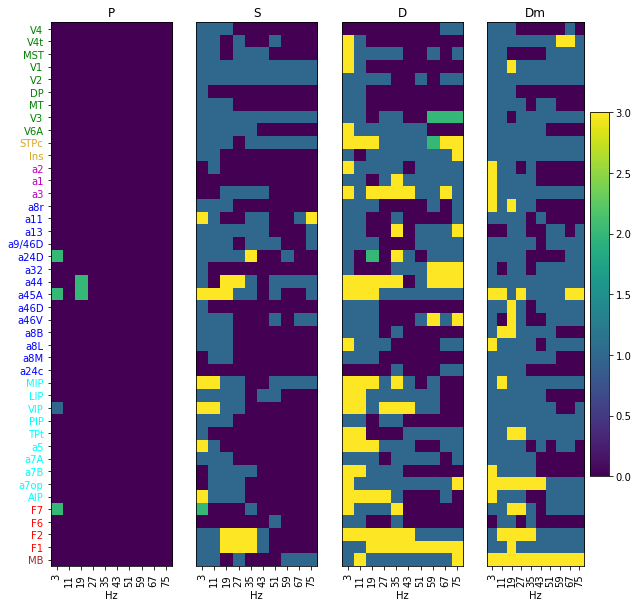

In [212]:
plt.figure(figsize=(10, 10))
plot_tile_maps(
    data,
    np.asarray([areas_dict[roi.lower()] for roi in power_pval.roi.data]),
    vmin=0,
    vmax=3,
)
plt.colorbar()
plt.savefig("sig_power_crackle.png")

In [223]:
cmi = []
for session in tqdm(sessions):

    kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

    power_task = data_loader.load_power(
        **kw_loader, trial_type=1, behavioral_response=1, session=session
    )

    power_fix = data_loader.load_power(
        **kw_loader, trial_type=2, behavioral_response=0, session=session
    )

    thr_fix = power_fix.quantile(0.9, ("trials", "times"))
    thr_task = power_task.quantile(0.9, ("trials", "times"))

    raster_fix = []
    raster_task = []

    for t0, t1 in tqdm(stages):
        raster_fix += [(power_fix >= thr_fix).sel(times=slice(t0, t1)).mean("times")]
        raster_task += [(power_task >= thr_task).sel(times=slice(t0, t1)).mean("times")]

    raster_task = xr.concat(raster_task, "times").transpose(*power_task.dims)
    raster_fix = xr.concat(raster_fix, "times").transpose(*power_task.dims)

    pp = compute_power_pval(power_task, power_fix, stages) <= 0.0001
    cp = compute_crackle_pval(raster_task, raster_fix, stages) <= 0.0001

    cmi += [
        ((cp.astype(int) + pp.astype(int)) == 2)
        / (cp.astype(int).sum("roi") + pp.astype(int).sum("roi"))
    ]

100%|██████████| 62/62 [11:53<00:00, 11.51s/it]


In [234]:
cmi_ = data_loader.apply_min_rois(cmi, 10)

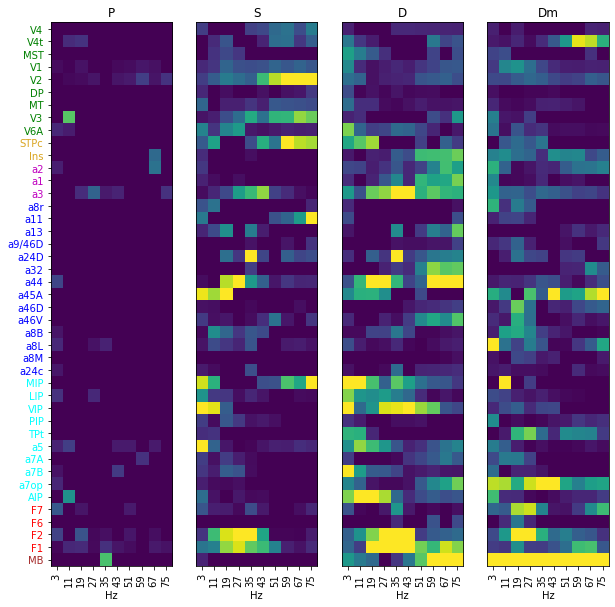

In [235]:
plt.figure(figsize=(10, 10))
plot_tile_maps(
    node_xr_remove_sca(cmi_),
    np.asarray([areas_dict[roi.lower()] for roi in power_pval.roi.data]),
    vmin=0,
    vmax=0.01,
)